# Power Analysis for 500 Respondents

A brief exploration of how often one is able to identify significant differences for various effect sizes.

In [1]:
import numpy as np
import scipy as sp
import seaborn as sns

In [2]:
mean1 = .55
sd1 = .2

mean2 = .5
sd2 = .2

pop1 = np.random.normal(mean1, sd1, 1000000)
pop2 = np.random.normal(mean2, sd2, 1000000)

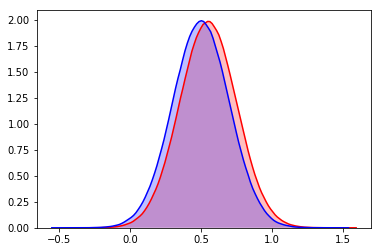

In [3]:
ax = sns.kdeplot(pop1, shade=True, color="r")
ax = sns.kdeplot(pop2, shade=True, color="b")

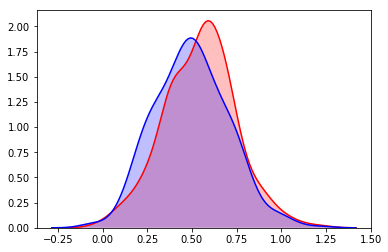

In [4]:
s1 = np.random.choice(pop1, 500, replace=False)
s2 = np.random.choice(pop2, 500, replace=False)

ax = sns.kdeplot(s1, shade=True, color="r")
ax = sns.kdeplot(s2, shade=True, color="b")

In [5]:
sp.stats.ttest_ind(s1,s2)[1]<.05

True

In [6]:
tests_signficant = 0
tests_not_signficant = 0

for i in range(100):
    s1 = np.random.choice(pop1, 500, replace=False)
    s2 = np.random.choice(pop2, 500, replace=False)
    if sp.stats.ttest_ind(s1,s2)[1]<.05:
        tests_signficant += 1
    else:
        tests_not_signficant += 1

print('tests significant: '+str(tests_signficant))
print('tests not significant: '+str(tests_not_signficant))

tests significant: 96
tests not significant: 4
